In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from 指标计算 import *

plt.rcParams['font.sans-serif']=['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus']=False   # 解决保存图像是负号'-'显示为方块的问题

In [2]:
rawData = cal_main('../DB/GFEX.csv', 'SI')
# 使用第二天的close值作为，每个样本的目标值
rawData['True_nClose'] = rawData['close'].shift(-1)
rawData.drop(rawData.index[-1], inplace=True)

## 代码聚合

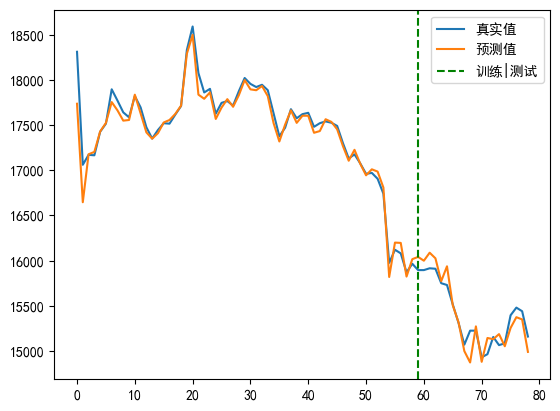

In [4]:
# 导入所需库
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 定义特征和目标值
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_close'
allField = features + [target]
# 数据读取
data = cal_main('../DB/GFEX.csv', 'SI')
# 使用第二天的close值作为，每个样本的目标值
data['next_close'] = data['close'].shift(-1)
data.drop(data.index[-1], inplace=True)
# 对每一列数据进行标准化
scaler = StandardScaler()
data[allField] = scaler.fit_transform(data[allField])
# 划分数据集为训练集和测试集
train_size = int(len(data) * 0.75)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
# 创建线性模型、训练拟合
lr = LinearRegression()
lr.fit(train_data[features], train_data[target])
# 预测结果
train_predictions = lr.predict(train_data[features])
test_predictions = lr.predict(test_data[features])
pre = np.hstack([train_predictions, test_predictions])
# 反标准化还原数据
preNew = data.copy()
dataNew = data.copy()
preNew['next_close'] = pre
dataNew[allField] = scaler.inverse_transform(dataNew[allField])
preNew[allField] = scaler.inverse_transform(preNew[allField])
# 画图
plt.plot(dataNew['close'], label='真实值')
plt.plot(preNew['next_close'], label='预测值')
plt.axvline(train_size, linestyle='--', color='green', label='训练|测试')
plt.legend()
rawData['线性回归'] = preNew['next_close']

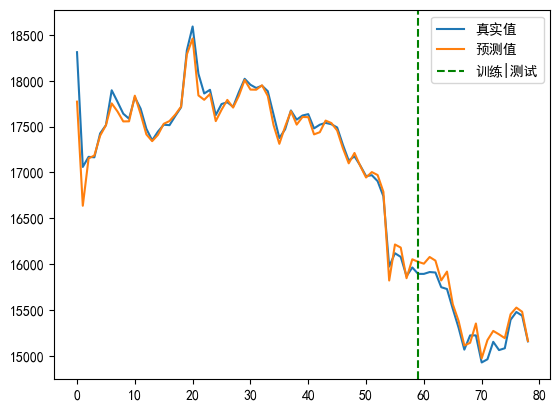

In [5]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# 定义特征和目标值
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_close'
allField = features + [target]
# 数据读取
data = cal_main('../DB/GFEX.csv', 'SI')
# 使用第二天的close值作为，每个样本的目标值
data['next_close'] = data['close'].shift(-1)
data.drop(data.index[-1], inplace=True)
# 对每一列数据进行标准化
scaler = StandardScaler()
data[allField] = scaler.fit_transform(data[allField])
# 划分数据集为训练集和测试集
train_size = int(len(data) * 0.75)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
# 创建岭回归模型并训练
alpha = 0.03 # 正则化参数
ridge = Ridge(alpha=alpha)
ridge.fit(train_data[features], train_data[target])
# 预测结果
train_predictions = ridge.predict(train_data[features])
test_predictions = ridge.predict(test_data[features])
pre = np.hstack([train_predictions, test_predictions])
# 反标准化还原数据
preNew = data.copy()
dataNew = data.copy()
preNew['next_close'] = pre
dataNew[allField] = scaler.inverse_transform(dataNew[allField])
preNew[allField] = scaler.inverse_transform(preNew[allField])
# 画图
plt.plot(dataNew['close'], label='真实值')
plt.plot(preNew['next_close'], label='预测值')
plt.axvline(train_size, linestyle='--', color='green', label='训练|测试')
plt.legend()
rawData['岭回归'] = preNew['next_close']

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# 读取数据
data = cal_main('../DB/GFEX.csv', 'SI')
# 定义特征和目标变量
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_change'
# 对每一列数据进行标准化
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])
# 计算涨跌情况
data['change'] = data['close'].diff().shift(-1)
data['next_change'] = data['change'].apply(lambda x: 1 if x > 0 else 0)
# 删除最后一个样本（目标变量为NaN）
data.drop(data.index[-1], inplace=True)
# 划分数据集为训练集和测试集
train_size = int(len(data) * 0.75)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
# 创建随机森林模型
rf = RandomForestClassifier(n_estimators=1, max_depth=3, random_state=0)
# 训练模型
rf.fit(train_data[features], train_data[target])
# 进行预测
train_predictions = rf.predict(train_data[features])
test_predictions = rf.predict(test_data[features])
# 计算模型准确率
train_accuracy = accuracy_score(train_data[target], train_predictions)
test_accuracy = accuracy_score(test_data[target], test_predictions)

print(f'训练集准确率:', train_accuracy)
print(f'测试集准确率:', test_accuracy)

data['nc_pre'] = np.concatenate((train_predictions, test_predictions))
data['res']  = np.where(data['next_change'] == data['nc_pre'], 1, 0)
rawData['随机森林'] = data['res']

训练集准确率: 0.7457627118644068
测试集准确率: 0.65


In [10]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# 定义特征和目标值
features = ['open', 'high', 'low', 'close', 'volume', 'open_interest', 'turnover']
target = 'next_close'
allField = features + [target]
# 数据读取
data = cal_main('../DB/GFEX.csv', 'SI')
# 使用第二天的close值作为，每个样本的目标值
data['next_close'] = data['close'].shift(-1)
data.drop(data.index[-1], inplace=True)
# 对每一列数据进行标准化
scaler = StandardScaler()
data[allField] = scaler.fit_transform(data[allField])
# 划分数据集为训练集和测试集
train_size = int(len(data) * 0.75)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]
# 建立滞后矩阵，转为LSTM需要的格式
def create_data(Atemp: pd.DataFrame, lookback=1):
    temp = Atemp.copy()
    temp = temp.reset_index()
    X = []
    Y = []
    for i in range(len(temp)-(lookback-1)):
        X.append(temp.loc[i:(i+lookback-1), features])
        Y.append(temp.loc[(i+lookback-1), target])
    return np.array(X), np.array(Y)
# 创建合适形状数据集
lookback = 3
X_train, Y_train = create_data(train_data, lookback)
X_test, Y_test = create_data(test_data, lookback)
# 定义模型
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(lookback, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# 训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=5, verbose=1)
# 预测训练集和测试集
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# 反标准化还原数据
dataNew = data.copy()
preNew = data.copy()


# # 对于预测部分损耗，填NaN
# preNew.loc[0:lookback-1, target] = np.nan
# preNew.loc[train_size:train_size+lookback-2, target] = np.nan
# # 把预测结果填入新表
# preNew.loc[lookback-1:train_size-1, target] = train_predict
# preNew.loc[train_size+lookback-1:, target] = test_predict

pre = np.vstack((train_predict, test_predict))
preNew['next_close'] = pre

# 还原数据
dataNew[allField] = scaler.inverse_transform(dataNew[allField])
preNew[allField] = scaler.inverse_transform(preNew[allField])
# 画图
plt.plot(dataNew['close'], label='真实值')
plt.plot(preNew['next_close'], label='预测值', color='#fe1593')
plt.axvline(train_size, linestyle='--', color='green', label='训练|测试')
plt.legend()

rawData['LSTM'] = preNew['next_close']

Epoch 1/100
12/12 [==============================] - 3s 4ms/step - loss: 0.4514
Epoch 2/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1994
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1653
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1348
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1266
Epoch 6/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1089
Epoch 7/100
12/12 [==============================] - 0s 3ms/step - loss: 0.1116
Epoch 8/100
12/12 [==============================] - 0s 5ms/step - loss: 0.0820
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.0996
Epoch 10/100
12/12 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 11/100
12/12 [==============================] - 0s 4ms/step - loss: 0.0837
Epoch 12/100
12/12 [==============================] - 0s 4ms/step - loss: 0.1001
Epoch 13/100
12/12 [=================

ValueError: Length of values (75) does not match length of index (79)

In [4]:
forestT = rawData[rawData['随机森林'] == 1]
forestF = rawData[rawData['随机森林'] == 0]

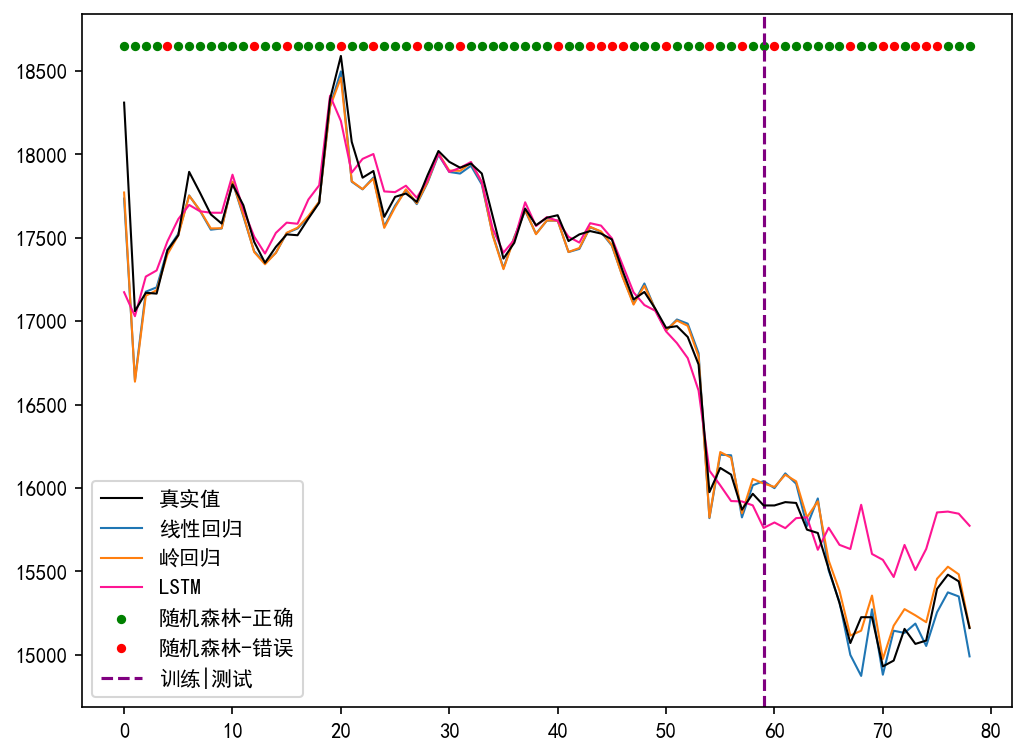

In [23]:
plt.figure(figsize=(8, 6), dpi=150)
lw = 1
plt.plot(rawData['close'], label='真实值', linewidth=lw, zorder=10, color='black')# 黑色
plt.plot(rawData['线性回归'], label='线性回归', linewidth=lw, color='#1f76b4')# 蓝色
plt.plot(rawData['岭回归'], label='岭回归', linewidth=lw, color='#ff7f0f')# 橙色
plt.plot(rawData['LSTM'], label='LSTM', linewidth=lw, color='#fe1593')# 粉色
plt.scatter(forestT.index.tolist(), [18650 for i in range(len(forestT))], label='随机森林-正确', s=12, color='green')
plt.scatter(forestF.index.tolist(), [18650 for j in range(len(forestF))], label='随机森林-错误', s=12, color='red')
plt.axvline(train_size, linestyle='--', color='purple', label='训练|测试')
plt.legend()

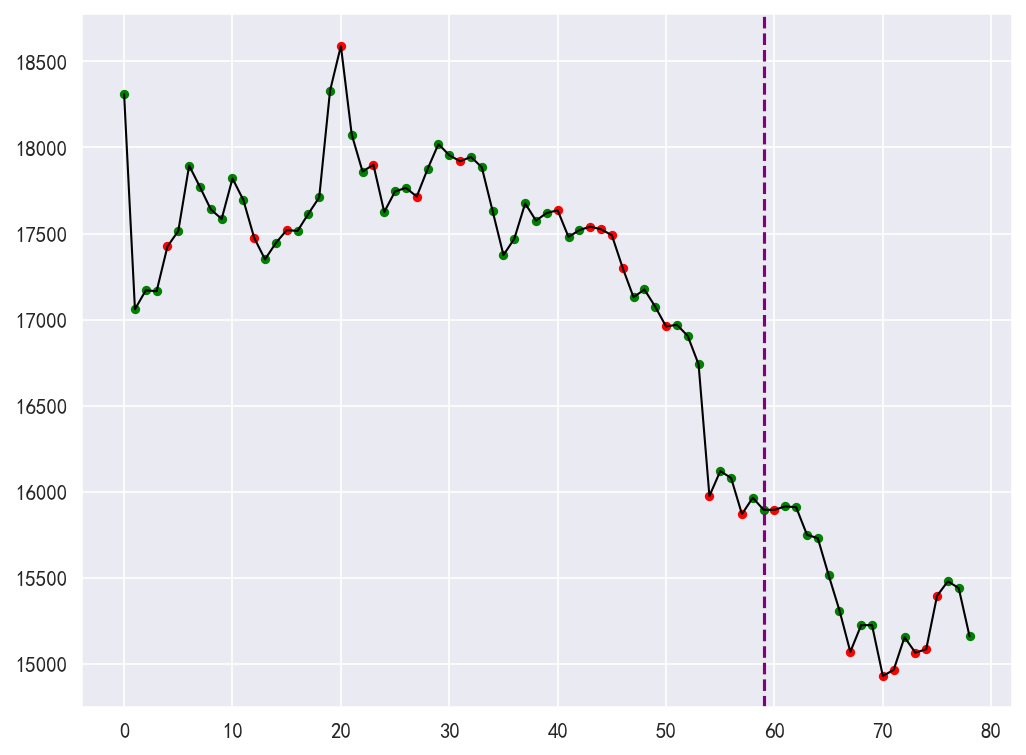

In [7]:
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(rawData['close'], label='真实值', linewidth=1, zorder=10, color='black')#
plt.scatter(forestT.index.tolist(), forestT['close'], label='随机森林-正确', s=12, color='green')
plt.scatter(forestF.index.tolist(), forestF['close'], label='随机森林-错误', s=12, color='red')
plt.axvline(train_size, linestyle='--', color='purple', label='训练|测试')